<a href="https://colab.research.google.com/github/AKP-shadow/AKP-shadow/blob/main/mediapipe_holistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Usage example of MediaPipe Holistic Solution API in Python (see also http://solutions.mediapipe.dev/holistic).

In [1]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 14.0 MB/s eta 0:00:00


Upload any image that that has a person. We take two example images from the web: https://unsplash.com/photos/v4zceVZ5HK8 and https://unsplash.com/photos/e_rhazQLaSs.


In [2]:
from google.colab import files
uploaded = files.upload()

Saving walking.jpg to walking.jpg


walking.jpg


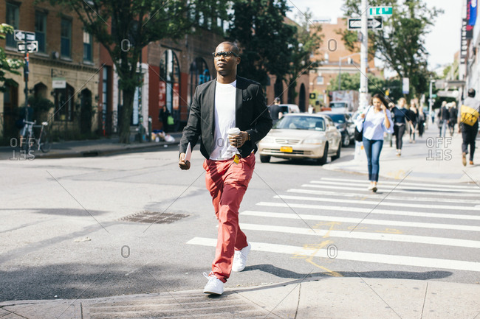

In [3]:
import cv2
from google.colab.patches import cv2_imshow
import math
import numpy as np

DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480
def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)

# Read images with OpenCV.
images = {name: cv2.imread(name) for name in uploaded.keys()}
# Preview the images.
for name, image in images.items():
  print(name)
  resize_and_show(image)

All MediaPipe Solutions Python API examples are under mp.solutions.

For the MediaPipe Pose solution, we can access this module as `mp_holistic = mp.solutions.holistic`.

You may change the parameters, such as `static_image_mode` and `min_detection_confidence`, during the initialization. Run `help(mp_holistic.Holistic)` to get more informations about the parameters.

In [4]:
import mediapipe as mp
mp_holistic = mp.solutions.holistic

help(mp_holistic.Holistic)

Help on class Holistic in module mediapipe.python.solutions.holistic:

class Holistic(mediapipe.python.solution_base.SolutionBase)
 |  Holistic(static_image_mode=False, model_complexity=1, smooth_landmarks=True, enable_segmentation=False, smooth_segmentation=True, refine_face_landmarks=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
 |  
 |  MediaPipe Holistic.
 |  
 |  MediaPipe Holistic processes an RGB image and returns pose landmarks, left and
 |  right hand landmarks, and face mesh landmarks on the most prominent person
 |  detected.
 |  
 |  Please refer to https://solutions.mediapipe.dev/holistic#python-solution-api
 |  for usage examples.
 |  
 |  Method resolution order:
 |      Holistic
 |      mediapipe.python.solution_base.SolutionBase
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, static_image_mode=False, model_complexity=1, smooth_landmarks=True, enable_segmentation=False, smooth_segmentation=True, refine_face_landmarks=Fa

In [5]:
# Import drawing_utils and drawing_styles.
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

Nose coordinates: (302.90138870477676, 80.78418570756912)
Pose landmarks of walking.jpg:


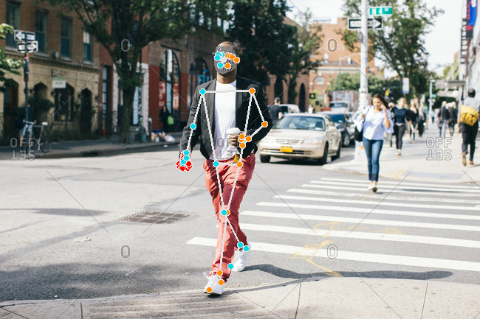

In [6]:
# Run MediaPipe Holistic and draw pose landmarks.
with mp_holistic.Holistic(
    static_image_mode=True, min_detection_confidence=0.5, model_complexity=2) as holistic:
  for name, image in images.items():
    # Convert the BGR image to RGB and process it with MediaPipe Pose.
    results = holistic.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Print nose coordinates.
    image_hight, image_width, _ = image.shape
    if results.pose_landmarks:
      print(
        f'Nose coordinates: ('
        f'{results.pose_landmarks.landmark[mp_holistic.PoseLandmark.NOSE].x * image_width}, '
        f'{results.pose_landmarks.landmark[mp_holistic.PoseLandmark.NOSE].y * image_hight})'
      )

    # Draw pose landmarks.
    print(f'Pose landmarks of {name}:')
    annotated_image = image.copy()
    mp_drawing.draw_landmarks(annotated_image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(annotated_image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(
        annotated_image,
        results.face_landmarks,
        mp_holistic.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
        .get_default_face_mesh_tesselation_style())
    mp_drawing.draw_landmarks(
        annotated_image,
        results.pose_landmarks,
        mp_holistic.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.
        get_default_pose_landmarks_style())
    resize_and_show(annotated_image)

Nose world landmark:
x: -0.01291472464799881
y: -0.6377664804458618
z: -0.24117907881736755
visibility: 0.9999942779541016

Pose world landmarks of walking.jpg:


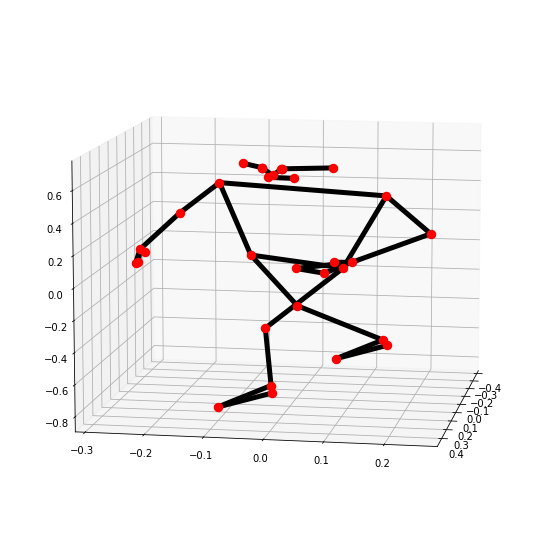

In [7]:
# Run MediaPipe Holistic and plot 3d pose world landmarks.
with  mp_holistic.Holistic(static_image_mode=True) as holistic:
  for name, image in images.items():
    results = holistic.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Print the real-world 3D coordinates of nose in meters with the origin at
    # the center between hips.
    print('Nose world landmark:'),
    print(results.pose_world_landmarks.landmark[mp_holistic.PoseLandmark.NOSE])
    
    # Plot pose world landmarks.
    print(f'Pose world landmarks of {name}:')
    mp_drawing.plot_landmarks(
        results.pose_world_landmarks, mp_holistic.POSE_CONNECTIONS)

Pose segmentation of walking.jpg:


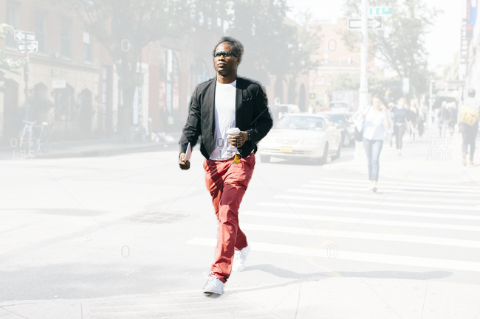

In [8]:
# Run MediaPipe Holistic with `enable_segmentation=True` to get pose segmentation.
with mp_holistic.Holistic(
    static_image_mode=True, enable_segmentation=True) as holistic:
  for name, image in images.items():
    results = holistic.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Draw pose segmentation.
    print(f'Pose segmentation of {name}:')
    annotated_image = image.copy()
    red_img = np.zeros_like(annotated_image, dtype=np.uint8)
    red_img[:, :] = (255,255,255)
    segm_2class = 0.2 + 0.8 * results.segmentation_mask
    segm_2class = np.repeat(segm_2class[..., np.newaxis], 3, axis=2)
    annotated_image = annotated_image * segm_2class + red_img * (1 - segm_2class)
    resize_and_show(annotated_image)